# MRG model validation

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import logging
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import mrg_lkp, mrgFiber, IextraMRGFiber, IintraMRGFiber, IntracellularCurrent, ExtracellularCurrent
from PySONIC.utils import logger, bounds, si_format
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve, plotFieldDistribution, plotFiberXCoords, plotMRGLookups

logger.setLevel(logging.INFO)

### Parameters

In [3]:
rs = 70.0      # Ohm.cm
nnodes = 21
pneuron = getPointNeuron('MRGnode')
fiberD = 10e-6  # um
fiberD_range = (5e-6, 20e-6)  # um
rho_ext = (300., 1200.)  # Ohm.cm
durations = np.logspace(-5, -1, 10)  # s
pp = PulsedProtocol(100e-6, 3e-3)  # s
correction_levels = ['axoplasmic', 'myelin']
dense_diameters = np.linspace(*fiberD_range, 10)  # m
sparse_diameters = np.array([5., 10., 20.]) * 1e-6  # m

### Functions

In [4]:
def plotSimIClamp(fiber, pp, I=None, ylim=None, title=None):
    if I is not None:
        polarity = 'cathode' if I < 0 else 'anode'
    else:
        polarity = 'anode'    
    source = IntracellularCurrent(fiber.nnodes // 2, I=I, mode=polarity)
    data, meta = fiber.simulate(source, pp)
    fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.nodeIDs).render()
    if ylim is not None:
        fig.axes[0].set_ylim(ylim)
    if title is not None:
        fig.axes[0].set_title(title)
    return fig

def plotSimExtSource(fiber, source, pp, ylim=None, title=None):
    data, meta = fiber.simulate(source, pp)
    fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.nodeIDs).render()
    if ylim is not None:
        fig.axes[0].set_ylim(ylim)
    if title is not None:
        fig.axes[0].set_title(title)
    return fig

def plotCVvsDiameter(diams, cv, fs=12):
    fig, ax = plt.subplots()
    ax.set_xlabel('diameter (um)', fontsize=fs)
    ax.set_ylabel('conduction velocity (m/s)', fontsize=fs)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    ax.plot(diams * 1e6, cv, '.', c='k')
    return fig

## Fiber model

### Morphological parameters

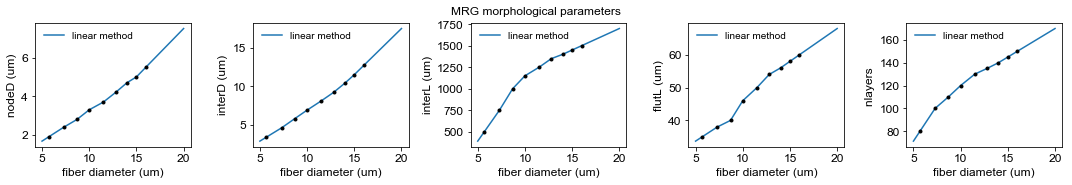

In [5]:
fig = plotMRGLookups(fiberD_range=fiberD_range)

### Construction variants

In [6]:
fiber_variants = {cl: mrgFiber(IintraMRGFiber, pneuron, fiberD, nnodes, rs, correction_level=cl) for cl in correction_levels}

#### Correction of axoplasmic parameters (as in McIntyre 2002)

In [7]:
fiber_variants['axoplasmic'].getSectionsDetails()

,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),xraxial (MOhms),xg (S/cm2),xc (uF/cm2)
node,21,1,3.3,1.000000,2.00,70.000000,337396.911461,1.000000e+10,0.000000
MYSA,40,1,10.0,3.000000,0.66,642.791552,337396.911461,4.166667e-06,0.000417
FLUT,40,1,10.0,46.000000,1.38,147.027935,80683.994905,4.166667e-06,0.000417
STIN,120,1,10.0,175.166667,1.38,147.027935,80683.994905,4.166667e-06,0.000417


#### Correction of myelin parameters

In [8]:
fiber_variants['myelin'].getSectionsDetails()

,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),xraxial (MOhms),xg (S/cm2),xc (uF/cm2)
node,21,1,3.3,1.000000,2.0,70.0,337396.911461,1.000000e+10,0.000000
MYSA,40,1,3.3,3.000000,2.0,70.0,337396.911461,1.262626e-05,0.001263
FLUT,40,1,6.9,46.000000,2.0,70.0,80683.994905,6.038647e-06,0.000604
STIN,120,1,6.9,175.166667,2.0,70.0,80683.994905,6.038647e-06,0.000604


### Morphology

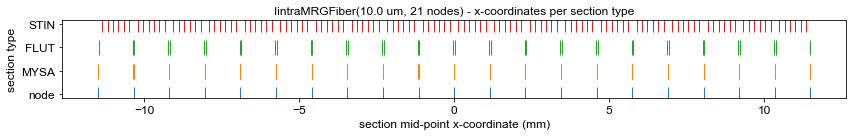

In [9]:
fig = plotFiberXCoords(fiber_variants['myelin'])

## Responses to intracellular stimulation

### Typical supra-threshold response (with both variants)

IintraMRGFiber(10.0 um, 21 nodes) with adjusted axoplasmic parameters:


 24/03/2020 17:28:02: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 10.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:02: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 20.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:03: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 40.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:04: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 80.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:05: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 160.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:05: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 320.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:06: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 640.0 pA), 100.

IintraMRGFiber(10.0 um, 21 nodes) with adjusted myelin parameters:


 24/03/2020 17:28:12: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 10.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:13: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 20.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:13: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 40.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:14: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 80.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:14: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 160.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:15: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 320.0 pA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:28:15: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 640.0 pA), 100.

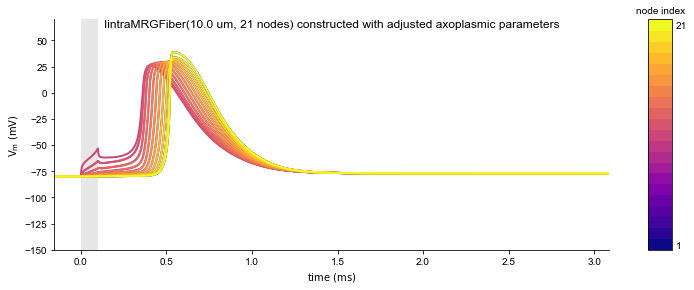

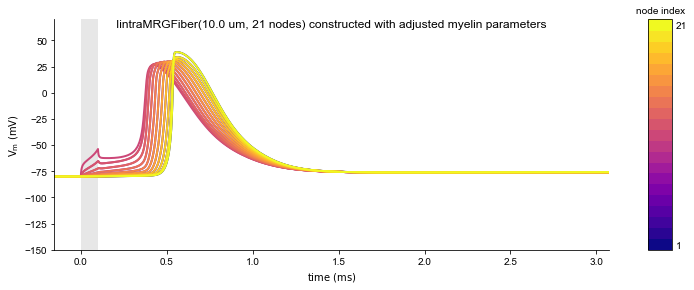

In [10]:
for cl, fiber in fiber_variants.items():
    print(f'{fiber} with adjusted {fiber.correction_level} parameters:')
    fig = plotSimIClamp(fiber, pp, title=f'{fiber} constructed with adjusted {fiber.correction_level} parameters')

### DAPs & AHPs following depolarizing pulses (McIntyre 2002, fig 2A)

 24/03/2020 17:28:22: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 1.2 nA), 100.0 us stim, 100.0 ms offset


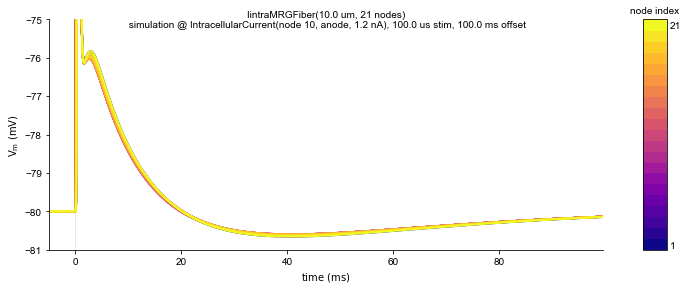

In [11]:
fig = plotSimIClamp(fiber_variants['myelin'], PulsedProtocol(100e-6, 100e-3), I=1.2e-9, ylim=(-81, -75))

We notice that both construction variants are equivalent and allow to reproduce the expected DAP and AHP.

### AHPs following hyperpolarizing pulses (McIntyre 2002, fig 2B)

 24/03/2020 17:28:24: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, cathode, -500.0 pA), 2.0 ms stim, 100.0 ms offset


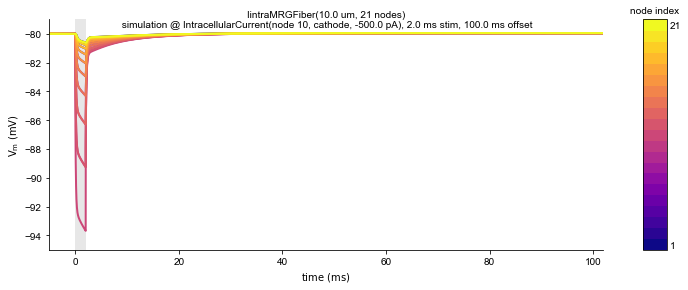

In [12]:
fig = plotSimIClamp(fiber_variants['myelin'], PulsedProtocol(2e-3, 100e-3), I=-0.5e-9, ylim=(-95, -79))

### Impulse-dependent AHP amplitude (McIntyre 2002, fig 6)

 24/03/2020 17:28:26: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 1.5 nA), 5.0 ms stim, 195.0 ms offset, 200.00 Hz PRF, 2.0% DC
 24/03/2020 17:28:27: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 1.5 nA), 15.0 ms stim, 185.0 ms offset, 200.00 Hz PRF, 2.0% DC
 24/03/2020 17:28:30: IintraMRGFiber(10.0 um, 21 nodes): simulation @ IntracellularCurrent(node 10, anode, 1.5 nA), 35.0 ms stim, 165.0 ms offset, 200.00 Hz PRF, 2.0% DC


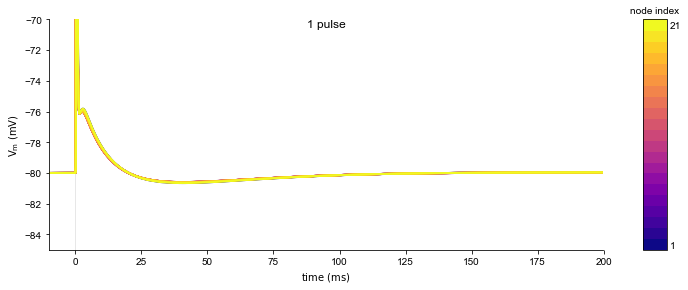

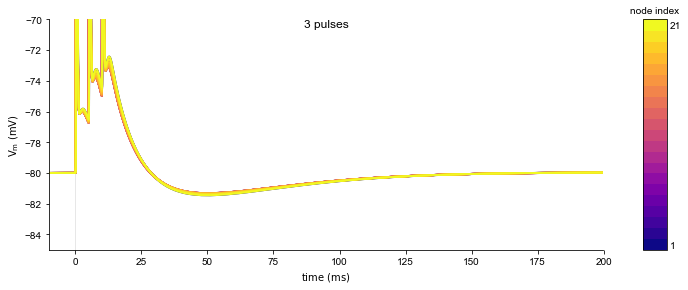

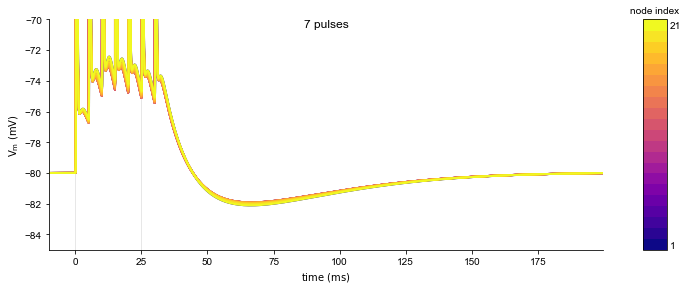

In [13]:
PW = 100e-6  # us
PRF = 200.0  # Hz
npulses = [1, 3, 7]
for n in npulses:
    tstim = n / PRF
    fig = plotSimIClamp(fiber, PulsedProtocol(tstim, 200e-3 - tstim, PRF, PW * PRF), I=1.5e-9,
                        ylim=(-85, -70), title=f'{n} pulse{"s" if n > 1 else ""}')

### Conduction velocity (McIntyre 2002, fig 8A)

In [14]:
logger.setLevel(logging.WARNING)
cv = []
for D in dense_diameters:
    fiber = mrgFiber(IintraMRGFiber, pneuron, D, nnodes, rs)
    print(f'computing conduction velocity for {fiber}')
    source = IntracellularCurrent(fiber.nnodes // 2)
    Ithr = fiber.titrate(source, pp)
    data, meta = fiber.simulate(source.updatedX(Ithr), pp)
    cv.append(fiber.getConductionVelocity(data))
logger.setLevel(logging.INFO)

computing conduction velocity for IintraMRGFiber(5.0 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(6.7 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(8.3 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(10.0 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(11.7 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(13.3 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(15.0 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(16.7 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(18.3 um, 21 nodes)
computing conduction velocity for IintraMRGFiber(20.0 um, 21 nodes)


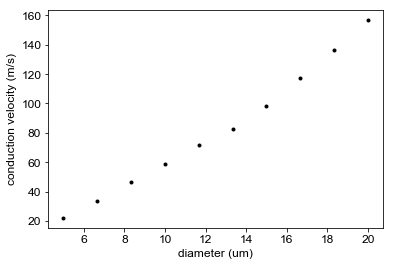

In [15]:
fig = plotCVvsDiameter(dense_diameters, cv)

### SD curves for varying diameters

In [16]:
logger.setLevel(logging.WARNING)
Iintra_thrs = {}
for D in sparse_diameters:
    fiber = mrgFiber(IintraMRGFiber, pneuron, D, nnodes, rs)
    source = IntracellularCurrent(fiber.nnodes // 2)
    print(f'computing thresholds for {fiber}')
    thrs = []
    for tstim in durations:
        print(f'   titration with {si_format(tstim, 2)}s pulse width ...')
        thrs.append(fiber.titrate(source, PulsedProtocol(tstim, 3e-3)))
    Iintra_thrs[f'{D * 1e6:.1f}um'] = np.array(thrs)
logger.setLevel(logging.INFO)

 24/03/2020 17:30:27: Rounding fiber diameter value (4.9999999999999996e-06) to interval lower bound (5e-06)


computing thresholds for IintraMRGFiber(5.0 um, 21 nodes)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titration with 35.94 ms pulse width ...
   titration with 100.00 ms pulse width ...
computing thresholds for IintraMRGFiber(10.0 um, 21 nodes)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titration with 35.94 ms pulse width ...
   titration with 100.00 ms pulse width ...
computing thresholds 

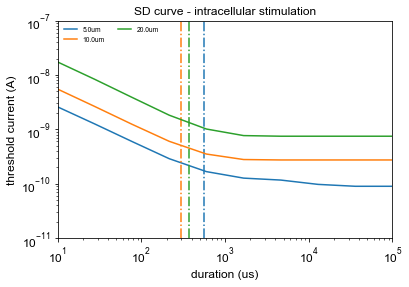

In [17]:
fig = strengthDurationCurve('SD curve - intracellular stimulation', durations, Iintra_thrs)

## Responses to extracellular stimulation

### Field distribution from point-source electrode in anisotropic medium

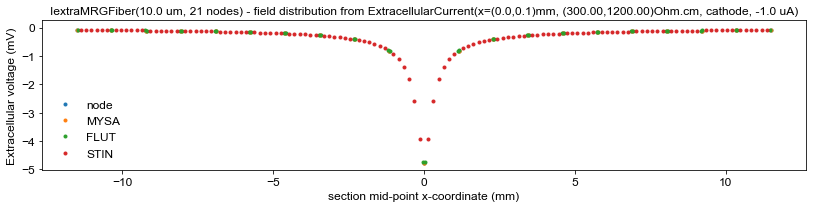

In [18]:
fiber = mrgFiber(IextraMRGFiber, pneuron, 10e-6, nnodes, rs, correction_level='axoplasmic')
ext_source = ExtracellularCurrent((0., 100e-6), rho=rho_ext)
fig = plotFieldDistribution(fiber, ext_source.updatedX(-1e-6))

### Typical supra-threshold response (with both construction variants)

#### Using equivalent intracellular currents (as in McIntyre 2002)

IextraMRGFiber(10.0 um, 21 nodes) with adjusted axoplasmic parameters:


 24/03/2020 17:36:25: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -2.1 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:26: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:26: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -8.4 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:27: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:28: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -6.3 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:28: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300

IextraMRGFiber(10.0 um, 21 nodes) with adjusted myelin parameters:


 24/03/2020 17:36:34: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -2.1 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:34: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:35: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -8.4 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:36: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:37: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -6.3 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:38: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300

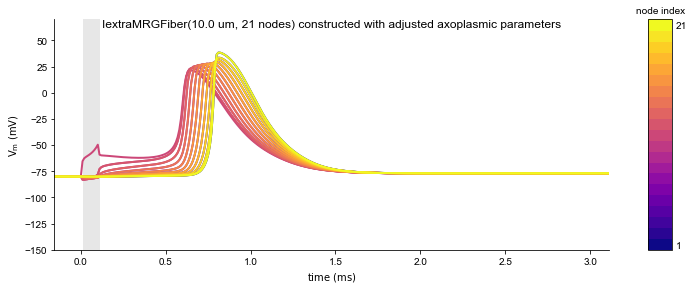

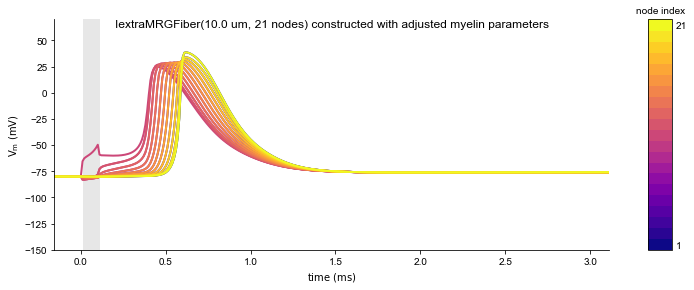

In [19]:
for cl in correction_levels:
    fiber = mrgFiber(IextraMRGFiber, pneuron, 10e-6, nnodes, rs, correction_level=cl)
    fiber.use_equivalent_currents = True
    print(f'{fiber} with adjusted {fiber.correction_level} parameters:')    
    fig = plotSimExtSource(fiber, ext_source.updatedX(None), pp, title=f'{fiber} constructed with adjusted {fiber.correction_level} parameters')

#### Using explicit setting of extracellular voltage

IextraMRGFiber(10.0 um, 21 nodes) with adjusted axoplasmic parameters:


 24/03/2020 17:36:43: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -2.1 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:43: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:44: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -8.4 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:45: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:45: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -6.3 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:46: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300

IextraMRGFiber(10.0 um, 21 nodes) with adjusted myelin parameters:


 24/03/2020 17:36:51: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -2.1 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:51: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:52: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -8.4 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:53: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -4.2 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:53: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode, -6.3 uA), 100.0 us stim, 3.0 ms offset
 24/03/2020 17:36:54: IextraMRGFiber(10.0 um, 21 nodes): simulation @ ExtracellularCurrent(x=(0.0,0.1)mm, (300

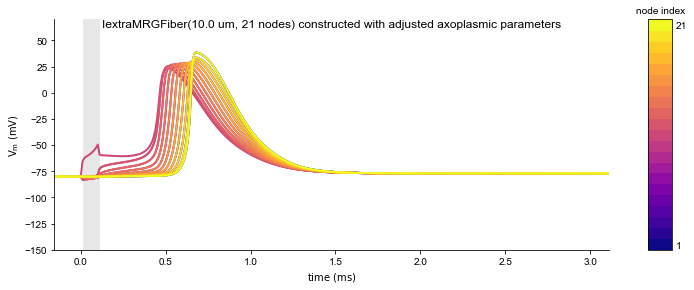

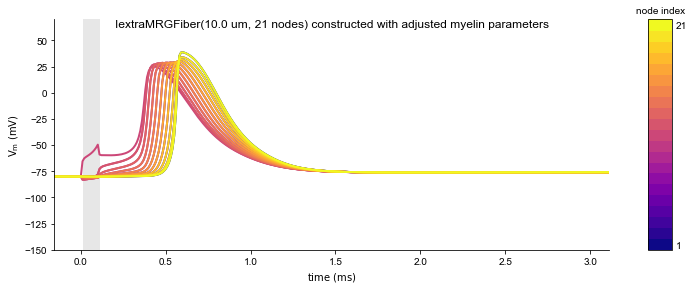

In [20]:
for cl in correction_levels:
    fiber = mrgFiber(IextraMRGFiber, pneuron, 10e-6, nnodes, rs, correction_level=cl)
    fiber.use_equivalent_currents = False
    print(f'{fiber} with adjusted {fiber.correction_level} parameters:')    
    fig = plotSimExtSource(fiber, ext_source.updatedX(None), pp, title=f'{fiber} constructed with adjusted {fiber.correction_level} parameters')

### SD curves for varying diameters

In [21]:
logger.setLevel(logging.WARNING)
Iextra_thrs = {}
for D in sparse_diameters:
    fiber = mrgFiber(IextraMRGFiber, pneuron, D, nnodes, rs)
    print(f'computing thresholds for {fiber}')
    thrs = []
    for tstim in durations:
        print(f'   titration with {si_format(tstim, 2)}s pulse width ...')
        thrs.append(fiber.titrate(ext_source, PulsedProtocol(tstim, 3e-3)))
    Iextra_thrs[f'{D * 1e6:.1f}um'] = np.array(thrs)
logger.setLevel(logging.INFO)

 24/03/2020 17:36:58: Rounding fiber diameter value (4.9999999999999996e-06) to interval lower bound (5e-06)


computing extracellular thresholds for IextraMRGFiber(5.0 um, 21 nodes)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titration with 35.94 ms pulse width ...
   titration with 100.00 ms pulse width ...
computing extracellular thresholds for IextraMRGFiber(10.0 um, 21 nodes)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titration with 35.94 ms pulse width ...
   titration with 100.00 ms pulse wid

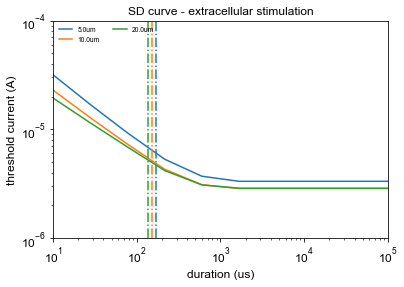

In [22]:
fig = strengthDurationCurve('SD curve - extracellular stimulation', durations, Iextra_thrs)

### SD curves for varying electrode locations (McIntyre 2002, fig 8B)

In [32]:
logger.setLevel(logging.WARNING)
fiber = mrgFiber(IextraMRGFiber, pneuron, fiberD, nnodes, rs)
xrange = np.linspace(0., fiber.interL / 2, 3)  # m
zrange = (np.arange(3) + 1) * 200e-6  # m
Iextra_thrs_vs_electrode_location = {}
for x in xrange:
    for z in zrange:
        ext_source = ExtracellularCurrent((x, z), rho=rho_ext)
        print(f'computing thresholds for {ext_source}')
        thrs = []
        for tstim in durations:
            print(f'   titration with {si_format(tstim, 2)}s pulse width ...')
            thrs.append(fiber.titrate(ext_source, PulsedProtocol(tstim, 3e-3)))
        Iextra_thrs_vs_electrode_location[ext_source.strPos()] = np.array(thrs)
logger.setLevel(logging.INFO)

computing extracellular thresholds for ExtracellularCurrent(x=(0.0,0.2)mm, (300.00,1200.00)Ohm.cm, cathode)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titration with 35.94 ms pulse width ...
   titration with 100.00 ms pulse width ...
computing extracellular thresholds for ExtracellularCurrent(x=(0.0,0.4)mm, (300.00,1200.00)Ohm.cm, cathode)
   titration with 10.00 us pulse width ...
   titration with 27.83 us pulse width ...
   titration with 77.43 us pulse width ...
   titration with 215.44 us pulse width ...
   titration with 599.48 us pulse width ...
   titration with 1.67 ms pulse width ...
   titration with 4.64 ms pulse width ...
   titration with 12.92 ms pulse width ...
   titrat

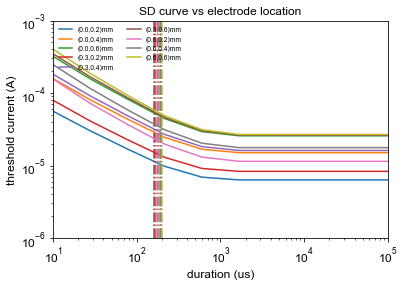

In [33]:
fig = strengthDurationCurve('SD curve vs electrode location', durations, Iextra_thrs_vs_electrode_location)

#### Rheobase-normalized

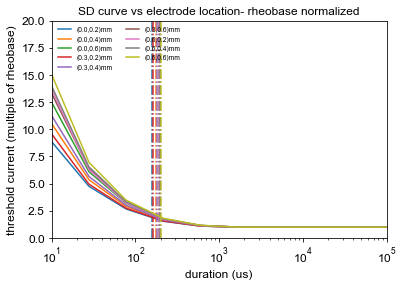

In [55]:
norm_Iextra_thrs_vs_electrode_location = {k: v / v[-1] for k, v in Iextra_thrs_vs_electrode_location.items()}
fig = strengthDurationCurve('SD curve vs electrode location- rheobase normalized', durations, norm_Iextra_thrs_vs_electrode_location, scale='log', yunit='multiple of rheobase')
fig.axes[0].set_yscale('linear');
fig.axes[0].set_ylim(0., 20.);

### Threshold stimulus for varying electrode-axon distances (McIntyre 2002, fig 8C)

In [35]:
logger.setLevel(logging.WARNING)
zrange_dense = np.linspace(100e-6, 1e-3, 10)  # m
Iextra_thrs_vs_electrode_distance = {}
ext_source = ExtracellularCurrent((0., 0.), rho=rho_ext)
for D in sparse_diameters:
    fiber = mrgFiber(IextraMRGFiber, pneuron, D, nnodes, rs)
    print(f'computing thresholds for {fiber}')
    thrs = []
    for z in zrange_dense:
        ext_source.x = (0., z)
        print(f'   titration with {ext_source} ...')
        thrs.append(fiber.titrate(ext_source, pp))
    Iextra_thrs_vs_electrode_distance[f'{D * 1e6:.1f}um'] = np.array(thrs)
logger.setLevel(logging.INFO)

 24/03/2020 18:20:15: Rounding fiber diameter value (4.9999999999999996e-06) to interval lower bound (5e-06)


computing thresholds for IextraMRGFiber(5.0 um, 21 nodes)
   titration with ExtracellularCurrent(x=(0.0,0.1)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.2)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.3)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.4)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.5)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.6)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.7)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.8)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,0.9)mm, (300.00,1200.00)Ohm.cm, cathode) ...
   titration with ExtracellularCurrent(x=(0.0,1.0)mm, (300.00,1200.00)Ohm.cm, cathode) ...
computing thresholds for IextraM

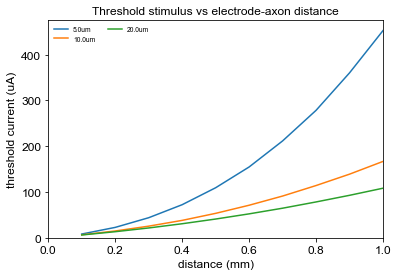

In [45]:
fig = strengthDistanceCurve('Threshold stimulus vs electrode-axon distance', zrange_dense, Iextra_thrs_vs_electrode_distance, scale='lin', yfactor=1e6)